In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch
from utils import train_model, test_model, gradcam_viz, lime_viz
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Traning Classifier

In [3]:
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-90, 90)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}


In [4]:
data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'val', 'test']}

batch_size = 16
num_workers = 2
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


## Densenet_121

In [9]:
densenet121 = models.densenet121(pretrained=True)
num_labels = 2

# Dropout applied after pretrained model as not all features are directly useful
densenet121_model = nn.Sequential(densenet121,
                                  nn.Dropout(p=0.2),
                                  nn.Linear(1000, 128),
                                  nn.ReLU(),
                                  nn.Linear(128, num_labels),
                                  nn.LogSoftmax(dim=1)
                                  )


densenet121_model = densenet121_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(densenet121_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

densenet121_model = train_model(densenet121_model, criterion, optimizer, exp_lr_scheduler,
                                dataloaders, dataset_sizes, device, num_epochs=50)


Epoch 1/50
----------------
train loss: 0.3417 acc: 0.8455
val loss: 0.2292 acc: 0.9120

Epoch 2/50
----------------
train loss: 0.2327 acc: 0.9131
val loss: 0.2744 acc: 0.8904

Epoch 3/50
----------------
train loss: 0.2013 acc: 0.9240
val loss: 0.1758 acc: 0.9330

Epoch 4/50
----------------
train loss: 0.1797 acc: 0.9359
val loss: 0.1780 acc: 0.9232

Epoch 5/50
----------------
train loss: 0.1755 acc: 0.9374
val loss: 0.1936 acc: 0.9281

Epoch 6/50
----------------
train loss: 0.1613 acc: 0.9431
val loss: 0.1467 acc: 0.9525

Epoch 7/50
----------------
train loss: 0.1486 acc: 0.9462
val loss: 0.2550 acc: 0.9176

Epoch 8/50
----------------
train loss: 0.1270 acc: 0.9550
val loss: 0.1627 acc: 0.9469

Epoch 9/50
----------------
train loss: 0.1144 acc: 0.9589
val loss: 0.1583 acc: 0.9490

Epoch 10/50
----------------
train loss: 0.1114 acc: 0.9618
val loss: 0.1600 acc: 0.9448

Epoch 11/50
----------------
train loss: 0.1092 acc: 0.9613
val loss: 0.1487 acc: 0.9567

Epoch 12/50
-------

## Testing model for results

In [20]:
results = test_model(densenet121_model,dataloaders['test'],dataset_sizes['test'],device,optimizer,criterion,f1='micro')
results

{'Accuracy': 0.962, 'F1 score': 0.962, 'Loss': 0.104}

In [21]:
torch.save(densenet121_model, "model_densenet121_96%.pt")

### We got 96% accuracy on test data, now we can proceed with explainability

### Model Explainability with GradCam and LIME

In [2]:
model = torch.load('model_densenet121_96%.pt')

In [3]:
# Loaging data with no transforms
batch_size = 16
num_workers = 2
data_dir = 'data'

dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'))
dataset_size = len(dataset_test)
class_names = dataset_test.classes


100%|██████████| 200/200 [00:01<00:00, 136.64it/s]


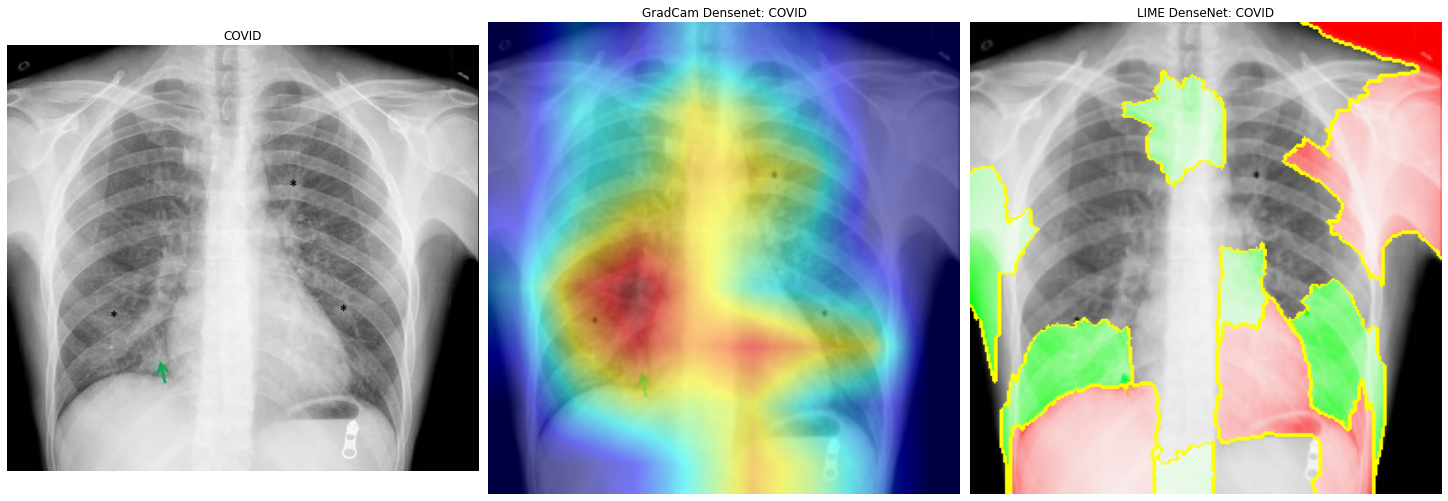

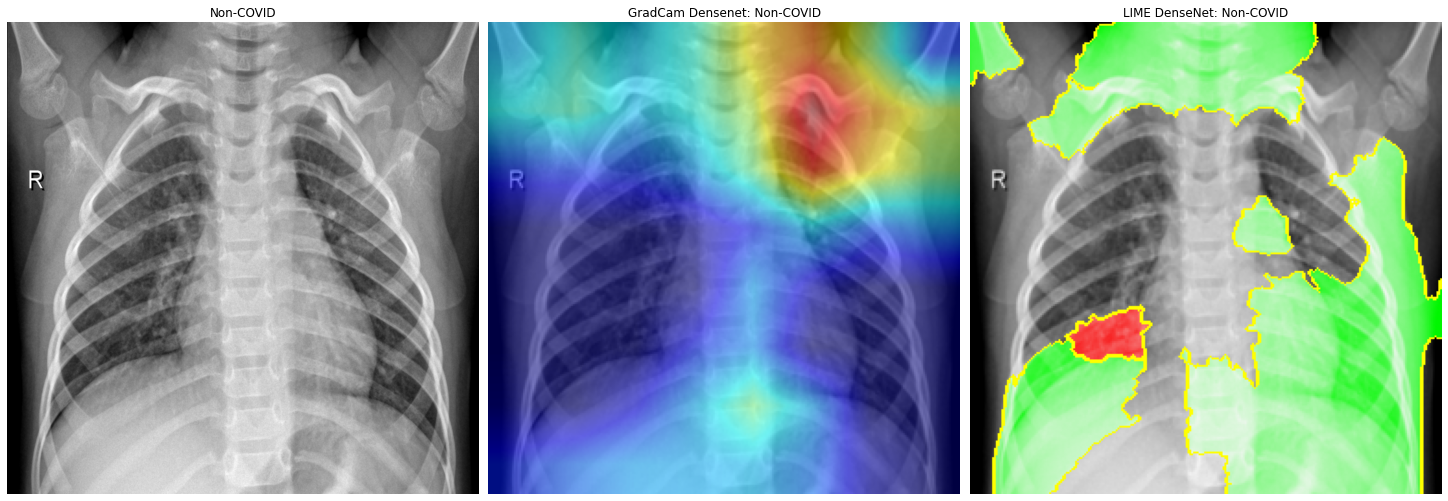

In [4]:
# Make plots for arbitrary choosen data test examples
for i in [0, 1000]:
    image_pil, label = dataset_test[i]
    actual_label = class_names[label]

    # Using functions from utils,
    # transforms for data can be specidied inside functions
    img_boundry, prediction = lime_viz(image_pil, model, device, class_names)
    visualization_densenet, preds_densenet = gradcam_viz(model, model[0].features.denseblock4.denselayer16.conv2,
                                                         image_pil, label, device)

    # Ploting part
    fig, ax = plt.subplots(1, 3, figsize=(20, 10), constrained_layout=True)
    ax[0].imshow(image_pil)
    ax[0].set_title(actual_label)
    ax[1].imshow(visualization_densenet)
    ax[1].title.set_text(f"GradCam Densenet: {class_names[preds_densenet]}")
    ax[2].imshow(img_boundry)
    ax[2].set_title(f'LIME DenseNet: {prediction}')

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
